In [1]:
import os
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from apelfei.statistics import fpf_2_gaussian_sigma, gaussian_sigma_2_fpf, TTest, LaplaceBootstrapTest
from apelfei.contrast import ContrastResults, collect_all_data_setup_configs, estimate_stellar_flux
from apelfei.utils import flux_ratio2mag, mag2flux_ratio, AperturePhotometryMode
from apelfei.utils.data_handling import load_adi_data

Found installation of parallel_sort and use it.


## This code is about:

This code computes the contrast curves for different types of noise. The code is based on the residuals computed in the notebook 10_contrast_curves_compute_residuals. The result is the Plot 10 of the Paper

## Set colors used in the plot

In [2]:
color_palette = [sns.color_palette("colorblind")[0],
                 sns.color_palette("colorblind")[1]]

color_palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549)]

# Load all config files and residuals

In [3]:
experiment_root = "../../../70_results/part1/detection_limits/Beta_Pic_non_stacked/"

In [4]:
all_configs = collect_all_data_setup_configs(os.path.join(experiment_root, 
                                                          "configs_cmap"))

In [5]:
# collect all the residual files with configs
all_method_results = dict()
algorithm_config_dir = os.path.join(experiment_root, "configs_algo")

for tmp_file in sorted(os.listdir(algorithm_config_dir)):
    # ignore system files
    if tmp_file.startswith("."):
        continue

    tmp_algo_config_file = os.path.join(algorithm_config_dir, tmp_file)
    with open(tmp_algo_config_file) as json_file:
        tmp_algorithm_config = json.load(json_file)
    
    tmp_algo = tmp_algorithm_config['method_name']
    print("Found algorithm config file for method " + str(tmp_algo))
    print("Collecting residuals...")
    
    # Loop over all fake planet experiments
    tmp_all_results = []
    for tmp_config in all_configs:
        tmp_id, tmp_cmap_config_file = tmp_config
        
        tmp_residual_file = os.path.join(experiment_root, 
                                         "pca_residuals",
                                         tmp_algo +"_ID_" + tmp_id + ".fits")
                  
        # save residual and config file paths
        tmp_all_results.append((tmp_cmap_config_file, tmp_residual_file))
        
    print("[DONE] - Found " + str(len(tmp_all_results)) + " residuals.")
    all_method_results[tmp_algo] = tmp_all_results

Found algorithm config file for method pca_005
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_010
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_020
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_030
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_040
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_050
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_075
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_100
[DONE] - Found 2017 residuals.


In [6]:
all_method_results["pca_005"][0]

('../../../70_results/part1/detection_limits/Beta_Pic_non_stacked/configs_cmap/exp_ID_0000.json',
 '../../../70_results/part1/detection_limits/Beta_Pic_non_stacked/pca_residuals/pca_005_ID_0000.fits')

# Read the data for the PSF template data

In [7]:
dataset_json_file = os.path.join(experiment_root, "dataset.json")
config_dir = os.path.join(experiment_root, "configs_cmap")
algo_config_root = os.path.join(experiment_root, "configs_algo")
residual_result_dir = os.path.join(experiment_root, "pca_residuals")

with open(dataset_json_file) as json_file:
    tmp_dataset_config = json.load(json_file)

In [8]:
tmp_dataset_config

{'file_path': '../../../30_data/BetaPic/betapic_naco_lp_full.hdf5',
 'stack_key': 'full_no_planet',
 'psf_template_key': 'flux',
 'parang_key': 'header_full/PARANG',
 'dit_psf_template': 0.02019,
 'dit_science': 0.2,
 'crop_science': 55,
 'crop_template': 82}

In [9]:
# we need the psf template for contrast calculation
science_data, _, raw_psf_template_data = load_adi_data(tmp_dataset_config["file_path"],
                                                       data_tag=tmp_dataset_config["stack_key"],
                                                       psf_template_tag=tmp_dataset_config["psf_template_key"],
                                                       para_tag=tmp_dataset_config["parang_key"])

dit_psf_template = tmp_dataset_config["dit_psf_template"]
dit_science = tmp_dataset_config["dit_science"]

In [10]:
# Cut the data to the innermost 8 lambda / D
crop_science = tmp_dataset_config["crop_science"]
crop_template = tmp_dataset_config["crop_template"]

science_data = science_data[:,
                            crop_science:-crop_science,
                            crop_science:-crop_science]

psf_template_data = raw_psf_template_data[crop_template:-crop_template, 
                                          crop_template:-crop_template]

test_frame = science_data[0, :, :]

## Create one Contrast Result Class for each PCA result

In [11]:
photometry_mode_planet = AperturePhotometryMode("FS", psf_fwhm_radius=2.1, search_area=0.5)
photometry_mode_noise = AperturePhotometryMode("P", psf_fwhm_radius=2.1)

In [12]:
# 1.) Compute the stellar flux
stellar_flux = estimate_stellar_flux(
    psf_template=psf_template_data,
    dit_science=tmp_dataset_config["dit_science"],
    dit_psf_template=tmp_dataset_config["dit_psf_template"],
    photometry_mode=photometry_mode_planet,
    scaling_factor=1.)

In [13]:
contrast_results = dict()

for pca_setup, result_files in all_method_results.items():
    print(pca_setup)
    tmp_contrast_result = ContrastResults(model_results_in=result_files,
                                          stellar_flux=stellar_flux,
                                          planet_photometry_mode=photometry_mode_planet,
                                          noise_photometry_mode=photometry_mode_noise,
                                          psf_fwhm_radius=2.1)
    contrast_results[pca_setup] = tmp_contrast_result

pca_005
pca_010
pca_020
pca_030
pca_040
pca_050
pca_075
pca_100


## Compute the contast curves 30 PCA components

In [14]:
ttest_statistic = TTest(1)

In [15]:
pbs_laplace_statistic = LaplaceBootstrapTest.construct_from_json_file(
    "../apelfei/statistics/lookup_tables/laplace_lookup_tables.csv")

In [16]:
tmp_result = contrast_results["pca_030"]

In [17]:
median_contrast_gauss, contrast_error_gauss = tmp_result.compute_contrast_curve(
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    test_statistic=ttest_statistic,
    num_rot_iterations=360)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [04:39<00:00, 17.44s/it]


In [18]:
median_contrast_laplace, contrast_error_laplace = tmp_result.compute_contrast_curve(
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    test_statistic=pbs_laplace_statistic,
    num_rot_iterations=360)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [08:13<00:00, 30.81s/it]


In [19]:
separations = [i / 4.2 for i in tmp_result.m_idx_table.index]

## Create the Plot

In [20]:
def plot_contrast_curve(separations,
                        median_contrast,
                        contrast_error,
                        label, 
                        axis, 
                        color):
    axis.plot(separations, 
              flux_ratio2mag(median_contrast), 
              label=label,
              lw=2,
              color=color)
    
    axis.fill_between(separations,
                      flux_ratio2mag(median_contrast + contrast_error * 2), 
                      flux_ratio2mag(median_contrast - contrast_error * 2),
                      alpha=0.5)

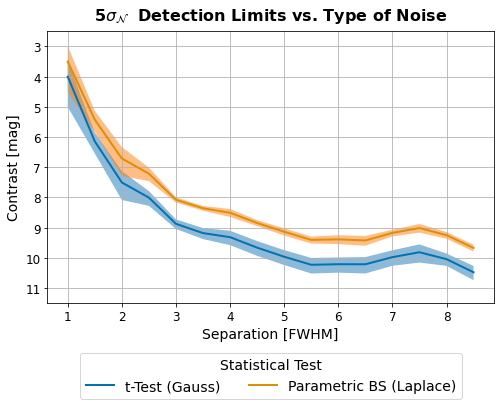

In [21]:
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(8, 5))
gs0 = fig.add_gridspec(1, 1)

axis_pca = fig.add_subplot(gs0[0, 0])

# 2.) Make the plot
plot_contrast_curve(separations, 
                    median_contrast_gauss, 
                    contrast_error_gauss,
                    "t-Test (Gauss)", 
                    axis_pca,
                    color=color_palette[0])

plot_contrast_curve(separations, 
                    median_contrast_laplace, 
                    contrast_error_laplace, 
                    "Parametric BS (Laplace)", 
                    axis_pca,
                    color=color_palette[1])

axis_pca.grid()

# 3.) Set limits
axis_pca.set_ylim(11.5, 2.5)
axis_pca.tick_params(axis='both', which='major', labelsize=12)

# 4.) Set Labels
axis_pca.set_xlabel(r"Separation [FWHM]", size=14)
axis_pca.set_ylabel(r"Contrast [mag]", size=14)

axis_pca.set_title(r"5$ \sigma_{\mathcal{N}}$  Detection Limits vs. Type of Noise",
                   fontsize=16, fontweight="bold", y=1.02)

# 5.) Legend
handles, labels = axis_pca.get_legend_handles_labels()
leg1 = fig.legend(handles, labels, 
                  bbox_to_anchor=(0.17, -0.16), 
                  fontsize=14, 
                  title="Statistical Test",
                  loc='lower left', ncol=2)
plt.setp(leg1.get_title(),fontsize=14)

# 5.) Save the Plot
fig.patch.set_facecolor('white')
plt.savefig("./10_Contrast_curves.pdf", 
            bbox_extra_artists=(leg1,), 
            bbox_inches='tight')